In [1]:
from analyze import *
import os

# mount flight data folder as you like


# look through flight_data folder for files containing "aug" (lowercase or uppercase)
# and print out the file names with numbers
# files = [f for f inekf_vel os.listdir("flight_data") if "okt10" in f.lower() or "sepaa" in f.lower()]
# for i, f in enumerate(files):
#     print(i, f)

In [19]:
path_1 = '../flight_data/Okt10_NN_long_oval_1.csv'
path_2 = '../flight_data/Okt10_NN_long_oval_2.csv'
path_4 = '../flight_data/Okt10_NN_long_oval_4.csv'
data_1 = load_flight_data(path_1)
data_2 = load_flight_data(path_2)
data_4 = load_flight_data(path_4)
data_1 = trim_nn_active(data_1)
data_2 = trim_nn_active(data_2)
data_4 = trim_nn_active(data_4)

data_4 = trim_time(data_4, 0, 7)
data = data_1

Loading ../flight_data/Okt10_NN_long_oval_1.csv
Logging frequency: 928.6831541270014
Loading ../flight_data/Okt10_NN_long_oval_2.csv
Logging frequency: 808.4233029186809
Loading ../flight_data/Okt10_NN_long_oval_4.csv
Logging frequency: 992.1192692549007


In [43]:
opti_indices = [i for i in range(len(data['t'])-1) if data['x_opti'][i]!=data['x_opti'][i+1]]
opti_time = data['t'][opti_indices]
print('opti freq:', 1/np.mean(np.diff(opti_time)))

dt = data['t'][1] - data['t'][0]
print('dt:', dt)



opti freq: 20.345881539288644
dt: 0.0012600000000020373


In [41]:
# reload analyze
import importlib
import analyze
importlib.reload(analyze)


# animate
# race track
# r = 1.5
# gate_pos = np.array([
#     [ r,  -r, -1.5],
#     [ 0,   0, -1.5],
#     [-r,   r, -1.5],
#     [ 0, 2*r, -1.5],
#     [ r,   r, -1.5],
#     [ 0,   0, -1.5],
#     [-r,  -r, -1.5],
#     [ 0,-2*r, -1.5]
# ])
# gate_yaw = np.array([1,2,1,0,-1,-2,-1,0])*np.pi/2

# long oval
gate_pos = np.array([
    [1.5, -5., -1.5],
    [1.5,  5., -1.5],
    [0.0, 6.5, -1.5],
    [-1.5, 5., -1.5],
    [-1.5, -5., -1.5],
    [0.0, -6.5, -1.5]
])
gate_yaw = np.array([0, 0, 0.5, 1, 1, 1.5])*np.pi+np.pi/2

animate_data_multiple2(data, gate_pos=gate_pos, gate_yaw=gate_yaw)

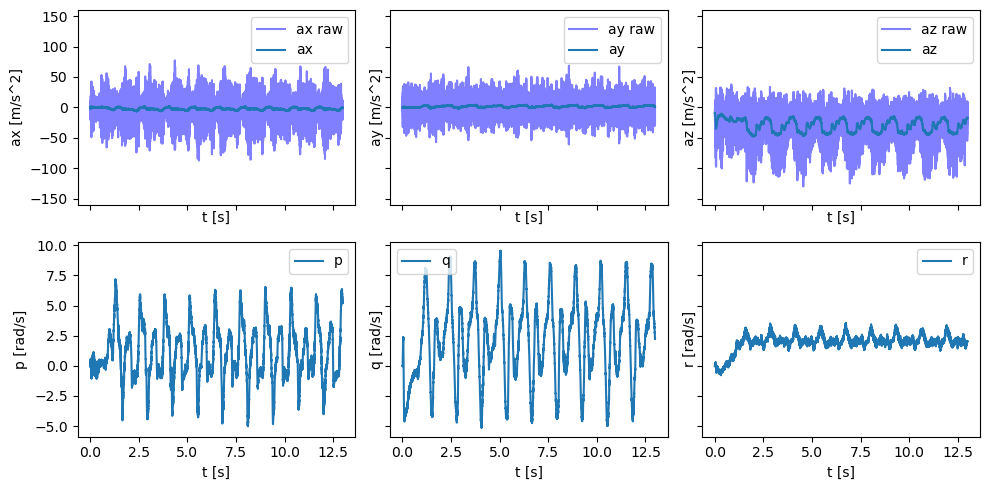

In [30]:
imu_plot(data)

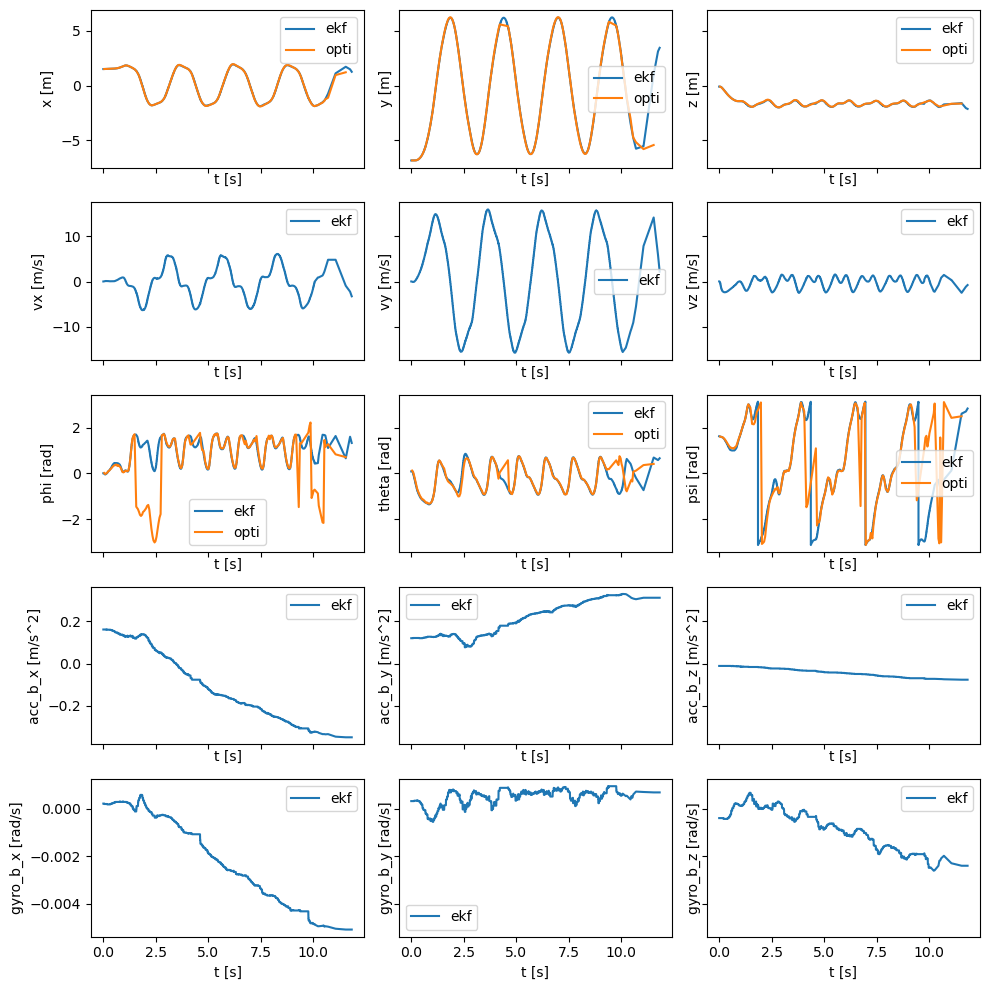

In [21]:
# NOT INLINE
ekf_plot(data)



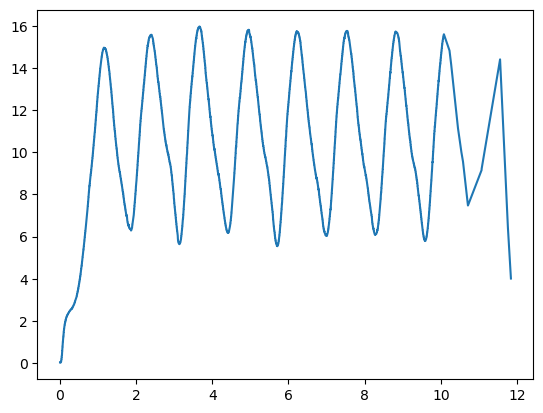

In [22]:
plt.plot(data['t'], data['v'])

In [20]:
""" How to process the data? 
How I do it is take a look at the individual CSV files by using the plot functions above,
then trimming the data to only have the NN, and use the trim_time to remove any hover/recovery part of the data. 
Interpolating is crusial for the rotations to work properly. Gets saved straight to txt so no csv needed
"""
import os
import numpy as np

def average_and_downsample(data):
    averaged_data = {}
    for key, values in data.items():
        if key == 't':
            # For time, just take every second point
            averaged_data[key] = values[::2]
        else:
            # For other data, take the average of each pair of points
            values_array = np.array(values)
            averaged_values = (values_array[:-1:2] + values_array[1::2]) / 2
            averaged_data[key] = averaged_values
    return averaged_data



data_1_downsampled = average_and_downsample(data_1)
data_2_downsampled = average_and_downsample(data_2)
data_4_downsampled = average_and_downsample(data_4)

k_w, k_x, k_y = fit_thrust_drag_model(data) # @Stavrow these are the drag params

# Output folders
output_train_folder = '/home/erin/DroneRacing/dronerace/filter/thrust_drag_model/train_and_validation_txt/data_train'
output_validation_folder = "/home/erin/DroneRacing/dronerace/filter/thrust_drag_model/train_and_validation_txt/data_validation"
train_splits_file = "/home/erin/DroneRacing/dronerace/filter/thrust_drag_model/train_and_validation_txt/splits_train/train_splits.txt"

# Scaling factors
acc_scale = 9.81 / float(2048)  # Scale for acceleration
gyro_scale = (np.pi / 180) / 10  # Scale for gyroscope
quat_scaling = ((127 << 6) - 1)  # Quaternion scaling
umin, umax = 0, 3000  # Fixed min/max values for motor RPM scaling If we specify a wmin above zero we might get negative values
pos_scale = 0.001  # Convert from mm to m
gravity_vector = np.array([0, 0, 9.81])  # Gravity vector

# Function to compute Euler angles from quaternions
def quat_to_euler(qw, qx, qy, qz):
    phi = np.arctan2(2 * (qw * qx + qy * qz), 1 - 2 * (qx**2 + qy**2))
    theta = np.arcsin(2 * (qw * qy - qz * qx))
    psi = np.arctan2(2 * (qw * qz + qx * qy), 1 - 2 * (qy**2 + qz**2))
    return phi, theta, psi

# Function to compute rotation matrix from Euler angles
def Rmat(phi, theta, psi):
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(phi), -np.sin(phi)],
                   [0, np.sin(phi), np.cos(phi)]])
    
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [-np.sin(theta), 0, np.cos(theta)]])
    
    Rz = np.array([[np.cos(psi), -np.sin(psi), 0],
                   [np.sin(psi), np.cos(psi), 0],
                   [0, 0, 1]])

    R = Rz @ Ry @ Rx
    return R



# Remove the train_splits.txt file if it exists
try:
    os.remove(train_splits_file)
except FileNotFoundError:
    pass

datasets = [data_1_downsampled, data_2_downsampled, data_4_downsampled]

print(data_1.keys)

remove_end_idx_in_split = 100 # should be updated if using longer training times


# Process files
for i, data in enumerate(datasets):
    output_folder = output_validation_folder if i == len(datasets) - 1 else output_train_folder
    output_file = os.path.join(output_folder, f'flight_data_{i+1}.txt')

    with open(output_file, mode='w') as outfile:
        num_rows = len(next(iter(data.values())))
        
        for count_idx in range(num_rows):
            extracted_data = []

            qw = float(data['qw'][count_idx])
            qx = float(data['qx'][count_idx])
            qy = float(data['qy'][count_idx])
            qz = float(data['qz'][count_idx])
            phi, theta, psi = quat_to_euler(qw, qx, qy, qz)

            # Compute body velocities and rates using the rotation matrix
            vel_world = [float(data['ekf_vx'][count_idx]), float(data['ekf_vy'][count_idx]), float(data['ekf_vz'][count_idx])]
            gyro_body = [float(data[f'gyroADCafterRpm[{j}]'][count_idx]) * gyro_scale for j in range(3)]
            unscaled_rpm = [float(data[f'omega[{j}]'][count_idx]) for j in range(4)]

            R_world_to_body = Rmat(phi, theta, psi).T
            gravity_body = R_world_to_body @ gravity_vector
            vel_body = R_world_to_body @ vel_world
            acc_z = float(data['az'][count_idx])
            accelerations = [float(data['ax'][count_idx]), float(data['ay'][count_idx]), float(data['az'][count_idx])]
            motor_rpm = [(float(data[f'omega[{j}]'][count_idx]) - umin) / (umax - umin) for j in range(4)]
            ekf_pos = [float(data['ekf_x'][count_idx]), float(data['ekf_y'][count_idx]), float(data['ekf_z'][count_idx])]
            time = float(data['t'][count_idx])

            # Write data to the file in the required order
            extracted_data.extend([f"{acc_z:.6f}"])
            extracted_data.extend([f"{gyro_body[j]:.6f}" for j in range(3)])  # Gyro rates
            extracted_data.extend([f"{qw:.6f}", f"{qx:.6f}", f"{qy:.6f}", f"{qz:.6f}"])  # Quaternions
            extracted_data.extend([f"{motor_rpm[j]:.6f}" for j in range(4)])  # Scaled motor RPMs [0, 1]
            extracted_data.extend([f"{vel_body[j]:.6f}" for j in range(3)])  # Body velocity (vx, vy, vz)
            extracted_data.extend([f"{gravity_body[j]:.6f}" for j in range(3)])  # Gravity vector in the body frame (gx, gy, gz)
            extracted_data.extend([f"{unscaled_rpm[j]:.6f}" for j in range(4)])  # Unscaled motor RPMs
            extracted_data.extend([f"{ekf_pos[j]:.6f}" for j in range(3)])  # EKF positions (x, y, z)
            extracted_data.extend([f"{phi:.6f}", f"{theta:.6f}", f"{psi:.6f}"])  # Euler angles
            extracted_data.extend([f"{accelerations[j]:.6f}" for j in range(3)])  # Accelerations

            outfile.write(' '.join(extracted_data) + '\n')
            if output_folder == output_train_folder:
                with open(train_splits_file, mode='a') as outsplitfile:
                    if count_idx < num_rows - remove_end_idx_in_split:
                        outsplitfile.write(f"flight_data_{i+1} {count_idx}\n")

    print(f"Extraction complete for flight data {i+1}. Data saved to {output_file}.")

print("All datasets processed.")


<built-in method keys of dict object at 0x75e4da254d80>
Extraction complete for flight data 1. Data saved to /home/erin/DroneRacing/dronerace/filter/thrust_drag_model/train_and_validation_txt/data_train/flight_data_1.txt.
Extraction complete for flight data 2. Data saved to /home/erin/DroneRacing/dronerace/filter/thrust_drag_model/train_and_validation_txt/data_train/flight_data_2.txt.
Extraction complete for flight data 3. Data saved to /home/erin/DroneRacing/dronerace/filter/thrust_drag_model/train_and_validation_txt/data_validation/flight_data_3.txt.
All datasets processed.
